# Deep Learning Tabular Data

In [1]:
%matplotlib inline
from utility_funcitons import *
from feature_selection import *
import pandas as pd 
import numpy as np


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_features, test_features, feature_names = featurize(train, test, 'tfidf_glove')

y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)

Starts with number....
Clickbait Phrases....
Clickbait re....
Num dots....
Text Features....
Punctuation....
Word ratios....
Sentiment Scores....
Readability Scores....



Glove.....



DONE!


In [2]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = 4, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)


def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))



In [3]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 40

simple_nn = Sequential()
simple_nn.add(Dense(150, activation='relu', input_shape=(119,)))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid'))

simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('./saved_models', monitor = 'val_accuracy', verbose = 1, save_best_only=True)

history = simple_nn.fit(train_features.todense(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint],
                    validation_data=(test_features.todense(), y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               18000     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 33,201
Trainable params: 33,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
58/79 [=====================>........] - 

Epoch 23/40
56/79 [====================>.........] - ETA: 0s - loss: 0.0394 - accuracy: 0.9852
Epoch 00023: val_accuracy did not improve from 0.98665
79/79 [==============================] - 0s 4ms/step - loss: 0.0390 - accuracy: 0.9856 - val_loss: 0.0404 - val_accuracy: 0.9852
Epoch 24/40
56/79 [====================>.........] - ETA: 0s - loss: 0.0448 - accuracy: 0.9835
Epoch 00024: val_accuracy did not improve from 0.98665
79/79 [==============================] - 0s 4ms/step - loss: 0.0409 - accuracy: 0.9858 - val_loss: 0.0391 - val_accuracy: 0.9860
Epoch 25/40
72/79 [==========================>...] - ETA: 0s - loss: 0.0331 - accuracy: 0.9883
Epoch 00025: val_accuracy did not improve from 0.98665
79/79 [==============================] - 0s 5ms/step - loss: 0.0347 - accuracy: 0.9875 - val_loss: 0.0649 - val_accuracy: 0.9764
Epoch 26/40
74/79 [===========================>..] - ETA: 0s - loss: 0.0383 - accuracy: 0.9849
Epoch 00026: val_accuracy did not improve from 0.98665
79/79 [======

In [4]:


from tensorflow.keras.models import load_model

simple_nn = load_model('./saved_models')

y_pred_prob = simple_nn.predict(test_features.todense())
print_model_metrics(y_test, y_pred_prob)

F1: 0.988 | Pr: 0.985 | Re: 0.991 | AUC: 0.999 | Accuracy: 0.988 



## Bagging

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

svm = SVC(C = 10, kernel = 'poly', degree = 2, probability = True, verbose = 0)

svm_bag = BaggingClassifier(svm, n_estimators = 200, max_features = 0.9, max_samples = 1.0, bootstrap_features = False, bootstrap = True, n_jobs = 1, verbose = 0)

svm_bag.fit(train_features, y_train)
y_test_prob = svm_bag.predict_proba(test_features)[:,1]
print_model_metrics(y_test, y_test_prob)

F1: 0.989 | Pr: 0.985 | Re: 0.992 | AUC: 0.999 | Accuracy: 0.989 



## Stacking Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log', alpha = 0.1, penalty = 'elasticnet')
svm = SVC(C = 10, kernel = 'poly', degree = 2, probability = True)
nb = MultinomialNB(alpha = 10000, class_prior = [0.5, 0.5])
knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', n_jobs = 2)
rf = RandomForestClassifier(n_estimators = 250, min_samples_split = 5, max_depth = 15,  n_jobs = -1)
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.3, max_depth = 1, n_jobs = -1)

model_dict = dict(zip(['LR', 'SVM', 'NB', 'KNN', 'XGB', 'RF'], [lr, svm, nb, knn, xgb, rf]))

for model_name, model in model_dict.items():
    print('Training {}'.format(model_name))
    if model_name == 'XGB':
        model.fit(train_features.todense(), y_train)
    else:
        model.fit(train_features, y_train)

model_weights = {   'LR' : 0.9,
                    'SVM' : 0.9,
                    'NB' : 0.8,
                    'KNN' : 0.75,
                    'RF' : 0.75,
                    'XGB' : 0.6,
                    'simple_nn' : 0.7
}

y_pred_prob = 0

for model_name, model in model_dict.items():
    if model_name == 'XGB':
        y_pred_prob += (model.predict_proba(test_features.todense())[:,1] * model_weights[model_name])
    else:
        y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob)

Training LR
Training SVM
Training NB
Training KNN
Training XGB
Training RF
F1: 0.989 | Pr: 0.988 | Re: 0.991 | AUC: 0.999 | Accuracy: 0.989 



In [8]:
def run_voting_clf(model_weights):
    y_pred_prob = 0

    for model_name, model in model_dict.items():
        if model_name == 'XGB':
            y_pred_prob += (model.predict_proba(test_features.todense())[:,1] * model_weights[model_name])
        else:   
            y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

    #y_pred_prob += (simple_nn.get_preds(ds_type = DatasetType.Valid)[0].numpy()[:,0] * model_weights['simple_nn'])
    y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
    y_pred_prob /= sum(model_weights.values())
    f1 = print_model_metrics(y_test, y_pred_prob, return_metrics = True, verbose = 0)[0]
    return {'loss' : -f1, 'status' : STATUS_OK}


In [12]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        'LR' : hp.uniform('LR', 0, 1),
        'SVM' : hp.uniform('SVM', 0, 1),
        'NB' : hp.uniform('NB', 0, 1),
        'KNN' : hp.uniform('KNN', 0, 1),
        'RF' : hp.uniform('RF', 0, 1),
        'XGB' : hp.uniform('XGB', 0, 1),
        'simple_nn' : hp.uniform('simple_nn', 0, 1),
    },
    algo=tpe.suggest,
    max_evals=5,
    trials = trials)


100%|██████████| 5/5 [02:58<00:00, 35.70s/trial, best loss: -0.9892741332002993]


F1: 0.990 | Pr: 0.989 | Re: 0.990 | AUC: 0.999 | Accuracy: 0.990 



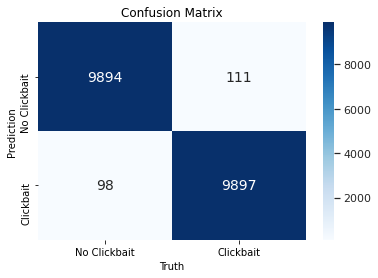

In [13]:
model_weights = {'KNN': 0.7866810233035141,
 'LR': 0.8036572275670447,
 'NB': 0.9102009774357307,
 'RF': 0.1559824350958057,
 'SVM': 0.9355079606348642,
 'XGB': 0.33469066125332436,
 'simple_nn': 0.000545264707939086}





y_pred_prob = 0
for model_name, model in model_dict.items():
    if model_name == 'XGB':
        y_pred_prob += (model.predict_proba(test_features.todense())[:,1] * model_weights[model_name])
    else:   
        y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())
print_model_metrics(y_test, y_pred_prob, confusion = True)



In [14]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
    
#Find the threshold value that gives the best F1 Score
best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

# Calulcate predictions based on the threshold value
y_test_pred = np.where(y_test_prob > best_threshold, 1, 0)

In [15]:
misclassified_idx = y_test != y_test_pred
high_confidence_indices = np.argsort(y_test_prob[misclassified_idx])[-10:]

In [16]:
for idx in high_confidence_indices:
    print('Title : {}'.format(test[misclassified_idx].title.values[idx]))
    print('Label : {}'.format(test[misclassified_idx].label.values[idx]))
    print('Predicted Probability : {}'.format(y_test_prob[misclassified_idx][idx]))
    print('-' * 10)

Title : My Swings With Annika
Label : not-clickbait
Predicted Probability : 0.9631409601320968
----------
Title : World Baseball Classic  Ticket Sales Show Where Rooting Interests Lie
Label : not-clickbait
Predicted Probability : 0.9691166598150531
----------
Title : Kosher Label Missing From Girl Scout Cookies
Label : not-clickbait
Predicted Probability : 0.9705094003007642
----------
Title : Big Movie Studios May Be Mightier Than Ever
Label : not-clickbait
Predicted Probability : 0.9707221228935105
----------
Title : Zoombak Tracks Your Dog, Your Car, Even Your Children
Label : not-clickbait
Predicted Probability : 0.9719694394944692
----------
Title : Curlers Prove Not All Brazilian Sweepers Play Soccer
Label : not-clickbait
Predicted Probability : 0.9766922964396215
----------
Title : Darwinism Must Die So That Evolution May Live
Label : not-clickbait
Predicted Probability : 0.9819721552009788
----------
Title : Exeem Annonunced To Be Successor Of Suprnova
Label : not-clickbait
Pre

In [17]:
test[test.label.values == 'not-clickbait'].sample(10).title.values

array(['Fiery Egyptian tourist bus crash kills nine',
       '5.6-magnitude aftershock earthquake strikes Italy',
       'Haiti votes in presidential runoff',
       'An iPhone Upgrade to Counter the Naysayers',
       'British soldier dies in Afghanistan, UK death toll rises to 222',
       'Blagojevich Calls Impeachment Process Unfair',
       'Last-Place Cyclist Fighting to Avoid Broom Wagon at Tour de France',
       "Michael Jackson's Neverland Ranch to be auctioned off",
       'How Product Placement Can Affect Stock Prices',
       'With New Name and Mission, the Infamous Abu Ghraib Prison Is to Reopen'],
      dtype=object)